In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

In [2]:
# Load your dataset
df = pd.read_csv('processed_data.csv')

Data Cleaning

Data Transformation

In [3]:
# Assuming 'State' and 'Play Type' are the only categorical columns needing encoding
categorical_features = ['Lithology']

In [4]:
# One-hot encoding for the categorical data
one_hot_encoder = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_features)], remainder='passthrough')
df_encoded = one_hot_encoder.fit_transform(df)

In [5]:
# Now df_encoded is a numpy array with one-hot encoded categorical features followed by the rest of the features
# You'll need to convert it back to a DataFrame if you want to keep the column labels
df_encoded = pd.DataFrame(df_encoded, columns=one_hot_encoder.get_feature_names_out())

In [6]:
df_encoded.corr()

,encoder__Lithology_Dolomite,encoder__Lithology_Limestone,encoder__Lithology_Sandstone,remainder__GeologicalFormationThickness(m),remainder__ReservoirThickness(m),remainder__GasPermeability(mD),remainder__LiquidPermeability(mD),remainder__RFC_P10,remainder__RFC_P25,remainder__RFC_P50,remainder__RFC_P75,remainder__RFC_P90
encoder__Lithology_Dolomite,1.000000,-0.017811,-0.311086,-0.009267,-0.005929,0.547861,0.547437,0.442761,0.426286,0.405927,0.383654,0.361612
encoder__Lithology_Limestone,-0.017811,1.000000,-0.944690,0.263757,0.167885,0.025610,0.013204,0.234192,0.249269,0.263434,0.274866,0.283409
encoder__Lithology_Sandstone,-0.311086,-0.944690,1.000000,-0.247670,-0.157635,-0.204050,-0.192119,-0.367840,-0.376767,-0.383553,-0.387114,-0.388004
remainder__GeologicalFormationThickness(m),-0.009267,0.263757,-0.247670,1.000000,0.856153,-0.005857,-0.009913,0.450731,0.485397,0.523825,0.560986,0.593198
remainder__ReservoirThickness(m),-0.005929,0.167885,-0.157635,0.856153,1.000000,-0.014936,-0.015960,0.473340,0.512763,0.558560,0.604770,0.646134
remainder__GasPermeability(mD),0.547861,0.025610,-0.204050,-0.005857,-0.014936,1.000000,0.999835,0.819163,0.788897,0.750954,0.708899,0.666842
remainder__LiquidPermeability(mD),0.547437,0.013204,-0.192119,-0.009913,-0.015960,0.999835,1.000000,0.815563,0.785052,0.746904,0.704708,0.662560
remainder__RFC_P10,0.442761,0.234192,-0.367840,0.450731,0.473340,0.819163,0.815563,1.000000,0.998495,0.992965,0.982898,0.969342
remainder__RFC_P25,0.426286,0.249269,-0.376767,0.485397,0.512763,0.788897,0.785052,0.998495,1.000000,0.997947,0.991424,0.981135
remainder__RFC_P50,0.405927,0.263434,-0.383553,0.523825,0.558560,0.750954,0.746904,0.992965,0.997947,1.000000,0.997745,0.991445


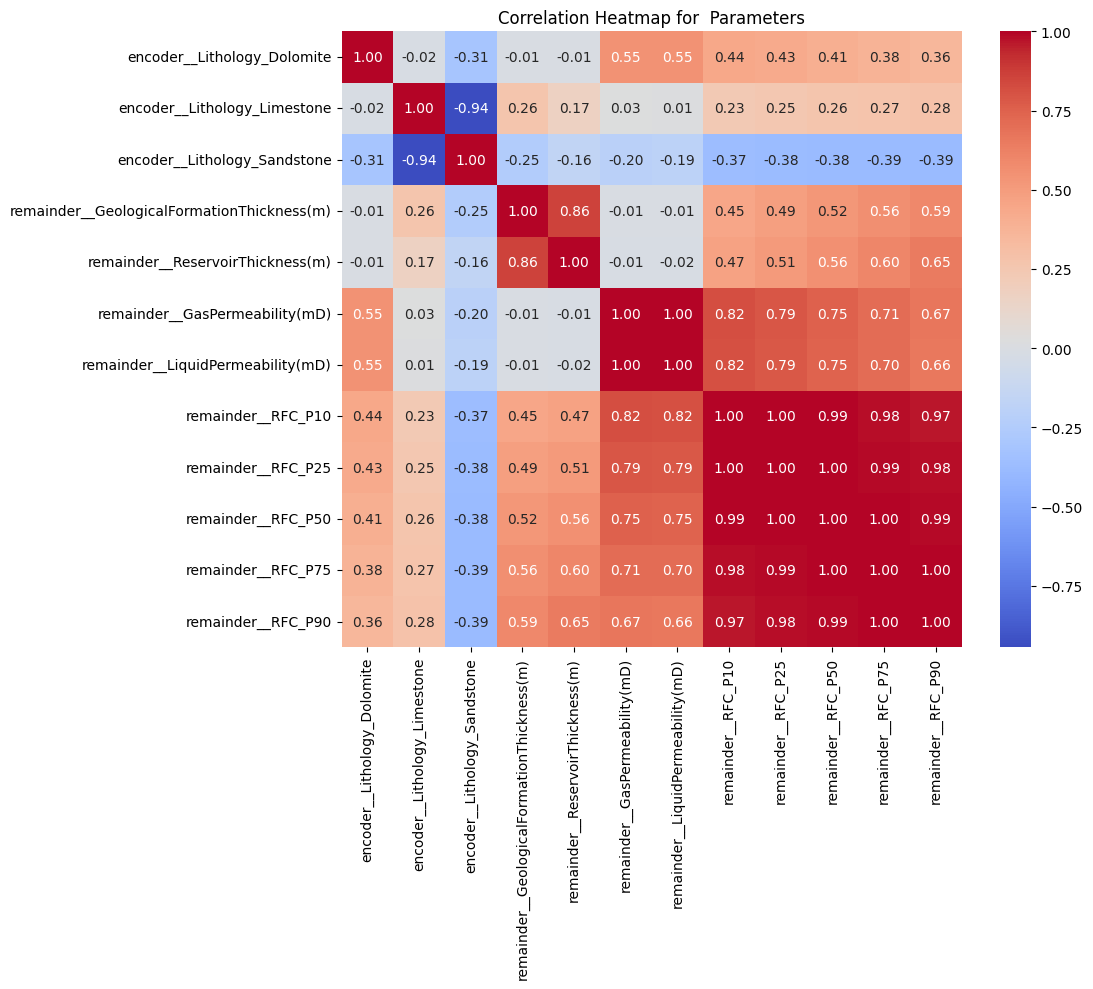

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for  Parameters')
plt.show()

In [8]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   encoder__Lithology_Dolomite                 1715 non-null   float64
 1   encoder__Lithology_Limestone                1715 non-null   float64
 2   encoder__Lithology_Sandstone                1715 non-null   float64
 3   remainder__GeologicalFormationThickness(m)  1715 non-null   float64
 4   remainder__ReservoirThickness(m)            1715 non-null   float64
 5   remainder__GasPermeability(mD)              1715 non-null   float64
 6   remainder__LiquidPermeability(mD)           1715 non-null   float64
 7   remainder__RFC_P10                          1715 non-null   float64
 8   remainder__RFC_P25                          1715 non-null   float64
 9   remainder__RFC_P50                          1715 non-null   float64
 10  remainder__R

Split to text and train

In [9]:
# Using iloc to separate features and targets
X = df_encoded.iloc[:, :7].values  # Selects all rows and columns up to but not including the 7th index
y = df_encoded.iloc[:, 9:10].values  # Targets are from the 7th column to the end

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random Forest

Using Gridsearch to get optimal n_estimates and min split

In [12]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],  # Number of trees in the forest
    'min_samples_split': [2, 5, 10, 20]            # Minimum number of samples required to split a node
}

In [13]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [14]:
rf = RandomForestRegressor(random_state=42)

In [15]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')

In [24]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200, 300, 400, 500]},
             scoring='neg_mean_squared_error')

In [25]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(-grid_search.best_score_))

Best parameters: {'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 9978.03


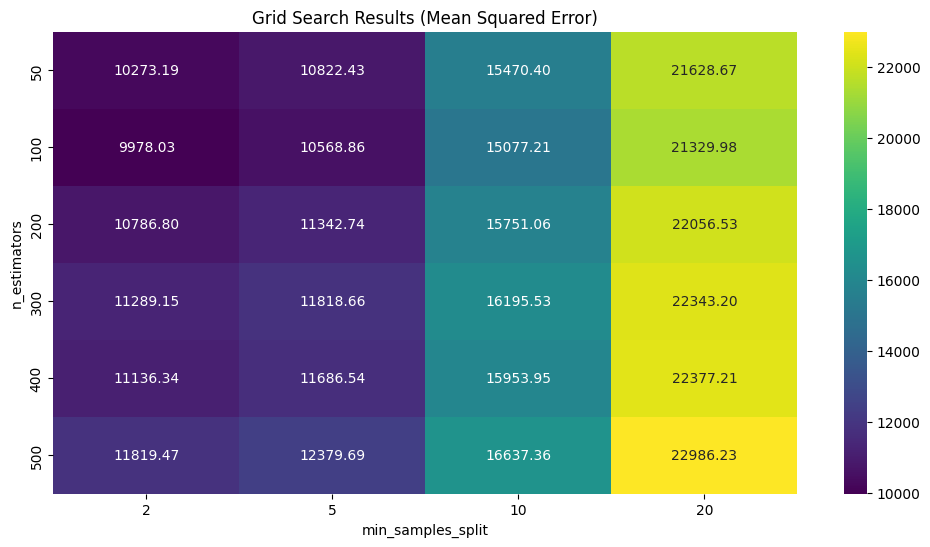

In [26]:
# Extract the results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Pivot the table to make 'min_samples_split' a column and 'n_estimators' an index
pivot_table = results.pivot(index='param_n_estimators', columns='param_min_samples_split', values='mean_test_score')

# Convert the negative MSE back to positive
pivot_table = -pivot_table

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.2f')
plt.title('Grid Search Results (Mean Squared Error)')
plt.xlabel('min_samples_split')
plt.ylabel('n_estimators')
plt.show()


Training with the optimal n_estimates

In [16]:
# Initialize the Random Forest Regressor for multi-target regression
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)

In [17]:
# Perform k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(random_forest_model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

In [18]:
# Training the model
random_forest_model.fit(X_train_scaled, y_train)

<ipython-input-18-c6972f6efa5c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_model.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [19]:
# Predictions can be made with model.predict(X_test_scaled)
predictions = random_forest_model.predict(X_test_scaled)

In [20]:
y_test

array([[9.7426e-01],
       [1.5309e+00],
       [2.1737e+00],
       [1.1444e+00],
       [2.0930e-02],
       [2.9918e+00],
       [8.7474e-01],
       [1.9692e+01],
       [1.2220e+00],
       [8.1330e-01],
       [1.8553e+00],
       [4.4057e-01],
       [1.1507e+00],
       [1.2220e+00],
       [1.2782e+00],
       [6.7821e-01],
       [1.2366e+00],
       [9.0910e-01],
       [1.2366e+00],
       [1.5025e+02],
       [1.2220e+00],
       [6.7800e-03],
       [2.9918e+00],
       [8.1897e-01],
       [4.4057e-01],
       [1.3920e+02],
       [1.2220e+00],
       [4.6276e-01],
       [1.8634e+00],
       [1.3475e+00],
       [1.0986e-01],
       [9.7818e-01],
       [2.9918e+00],
       [6.0488e+00],
       [1.1678e+00],
       [5.4248e-01],
       [1.9763e+01],
       [4.9391e+00],
       [1.1444e+00],
       [1.9692e+01],
       [8.7955e-01],
       [3.4495e+00],
       [1.3695e+01],
       [1.2782e+00],
       [7.0651e+00],
       [8.1302e-01],
       [6.5224e+00],
       [1.269

In [21]:
predictions

array([9.43020295e-01, 1.30533314e+00, 2.03252348e+00, 1.10836901e+00,
       2.13063667e-02, 2.99180000e+00, 1.08212163e+00, 1.96920000e+01,
       1.22200000e+00, 8.10368900e-01, 1.90907299e+00, 4.40570000e-01,
       1.18624912e+00, 1.22200000e+00, 1.27820000e+00, 6.06791063e-01,
       1.25177560e+00, 1.04803074e+00, 1.25177560e+00, 1.50250000e+02,
       1.22200000e+00, 6.93280000e-03, 2.99180000e+00, 8.39172299e-01,
       4.40570000e-01, 1.57248000e+02, 1.22200000e+00, 5.69535510e-01,
       1.92774414e+00, 1.35009542e+00, 2.40700200e-01, 9.43673837e-01,
       2.99180000e+00, 5.81682600e+00, 1.24281032e+00, 6.83676040e-01,
       1.97630000e+01, 4.90832200e+00, 1.10836901e+00, 1.96920000e+01,
       8.61115691e-01, 3.46021460e+00, 1.36950000e+01, 1.27820000e+00,
       6.68551800e+00, 7.39238636e-01, 6.73273900e+00, 1.21184891e+00,
       7.39238636e-01, 1.27820000e+00, 2.04856690e+00, 5.40448900e+00,
       2.47658400e+00, 6.12853114e-01, 1.61407787e+00, 1.23710482e+00,
      

In [ ]:
# Evaluate the model


In [22]:
# Now calculate the mean squared error (MSE) between the test labels and the predictions
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)

In [23]:
print("R-squared:", r_squared)
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Explained Variance Score:", explained_variance)
print(f'Cross-Validation RMSE: {np.sqrt(-cross_val_scores.mean())}')

R-squared: 0.9572878241408346
Mean Squared Error on Test Set: 746.134837632414
Root Mean Squared Error: 27.315468834204804
Mean Absolute Error: 4.65448556977796
Explained Variance Score: 0.9577855129589428
Cross-Validation RMSE: 99.93130059066947


In [45]:
# y_test_array = y_test.values

In [24]:
# Create a DataFrame to compare predictions side by side
comparison_df = pd.DataFrame({
    'Actual': y_test.flatten(),  # Flatten y_test if it's multi-dimensional
    'Predicted': predictions.flatten()  # Flatten predictions if necessary
})

# Display the first few rows of the DataFrame to inspect
print(comparison_df.head(30))

       Actual   Predicted
0     0.97426    0.943020
1     1.53090    1.305333
2     2.17370    2.032523
3     1.14440    1.108369
4     0.02093    0.021306
5     2.99180    2.991800
6     0.87474    1.082122
7    19.69200   19.692000
8     1.22200    1.222000
9     0.81330    0.810369
10    1.85530    1.909073
11    0.44057    0.440570
12    1.15070    1.186249
13    1.22200    1.222000
14    1.27820    1.278200
15    0.67821    0.606791
16    1.23660    1.251776
17    0.90910    1.048031
18    1.23660    1.251776
19  150.25000  150.250000
20    1.22200    1.222000
21    0.00678    0.006933
22    2.99180    2.991800
23    0.81897    0.839172
24    0.44057    0.440570
25  139.20000  157.248000
26    1.22200    1.222000
27    0.46276    0.569536
28    1.86340    1.927744
29    1.34750    1.350095


In [25]:
comparison_df.to_csv('RandomForest_comparison_df.csv', index=False)

Visualization

Feature Importance

In [37]:
column_names = ['encoder__Lithology_Dolomite', 'encoder__Lithology_Limestone',
                'encoder__Lithology_Sandstone', 'remainder__GeologicalFormationThickness(m)',
                'remainder__ReservoirThickness(m)', 'remainder__GasPermeability(mD)',
                'remainder__LiquidPermeability(mD)', 'remainder__RFC_P10',
                'remainder__RFC_P25', 'remainder__RFC_P50', 'remainder__RFC_P75',
                'remainder__RFC_P90']

# Remove prefixes from column names
modified_column_names = [name.replace('encoder__', '').replace('remainder__', '') for name in column_names]

print(modified_column_names)

['Lithology_Dolomite', 'Lithology_Limestone', 'Lithology_Sandstone', 'GeologicalFormationThickness(m)', 'ReservoirThickness(m)', 'GasPermeability(mD)', 'LiquidPermeability(mD)', 'RFC_P10', 'RFC_P25', 'RFC_P50', 'RFC_P75', 'RFC_P90']


In [38]:
df_encoded_features = modified_column_names

In [39]:
df_encoded_features[:7]

['Lithology_Dolomite',
 'Lithology_Limestone',
 'Lithology_Sandstone',
 'GeologicalFormationThickness(m)',
 'ReservoirThickness(m)',
 'GasPermeability(mD)',
 'LiquidPermeability(mD)']

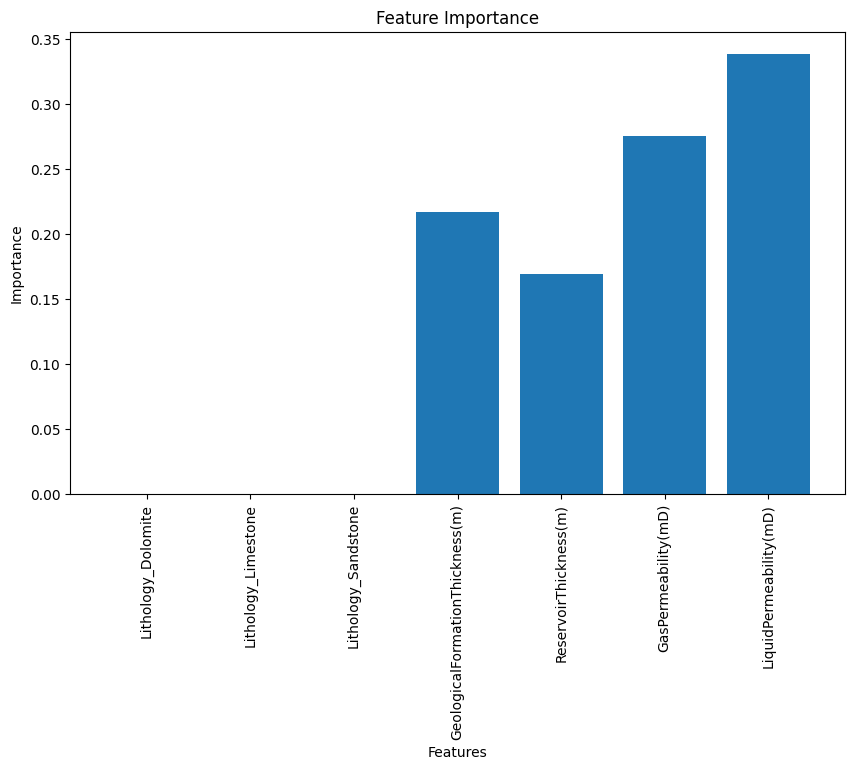

In [40]:
#Feature Importance Chart

feature_names = df_encoded_features[:7]


# Get feature importances
importances = random_forest_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

Tree Visualization

In [41]:
from sklearn.tree import export_graphviz
import graphviz

# Extract one tree from the forest
tree = random_forest_model.estimators_[0]

# Export the image to a dot file
dot_data = export_graphviz(tree, out_file=None,
                           feature_names=feature_names,
                           filled=True, rounded=True,
                           special_characters=True)

# Use graphviz to create the graph
graph = graphviz.Source(dot_data)
graph.render("tree")  # Saves the tree to a file called "tree.pdf"


'tree.pdf'

 Partial Dependence Plots

In [43]:
df_encoded.columns

Index(['encoder__Lithology_Dolomite', 'encoder__Lithology_Limestone',
       'encoder__Lithology_Sandstone',
       'remainder__GeologicalFormationThickness(m)',
       'remainder__ReservoirThickness(m)', 'remainder__GasPermeability(mD)',
       'remainder__LiquidPermeability(mD)', 'remainder__RFC_P10',
       'remainder__RFC_P25', 'remainder__RFC_P50', 'remainder__RFC_P75',
       'remainder__RFC_P90'],
      dtype='object')

In [44]:
# from pdpbox import pdp, build_dataset, info_plots

# # Create the partial dependence plot for the feature of interest
# feature_to_plot = 'encoder__Lithology_Sandstone'  # Example feature from the Boston dataset
# pdp_goals = pdp.pdp_isolate(model=random_forest_model, dataset=pd.DataFrame(X, columns=feature_names),
#                             model_features=feature_names, feature=feature_to_plot)

# pdp.pdp_plot(pdp_goals, feature_to_plot)
# plt.show()


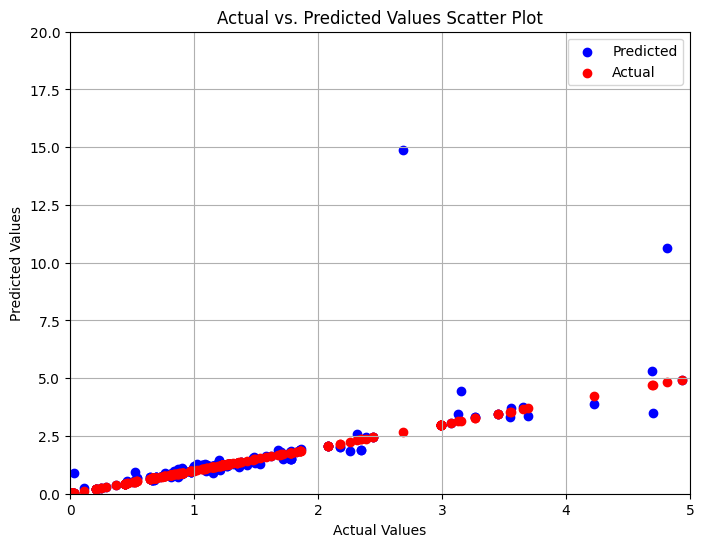

In [42]:
# Create a scatter plot of Actual vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['Actual'], comparison_df['Predicted'], color='blue', label='Predicted')
plt.scatter(comparison_df['Actual'], comparison_df['Actual'], color='red', label='Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values Scatter Plot')
plt.xlim(0, 5)  # Limit x-axis to 20
plt.ylim(0, 20)  # Limit y-axis to 20
plt.legend()
plt.grid(True)
plt.show()